###Slug test analysis in an unconfined aquifer

The data is taken from the [AQTESOLVE](http://www.aqtesolv.com/examples/uncslug1.htm) website. 

Butler (1998) presents results from a slug test in a partially penetrating well that is screened in unconsolidated alluvial deposits consisting of sand and gravel with interbedded clay. The aquifer has a thickness $H=47.87$ m. The depth to the top of the well screen is 16.7 m, and the screen of the well is 1.52 m long. The radius of the well is 0.125 m, and the radius of the casing is 0.064 m. The slug displacement is 0.671 m. 

In [1]:
from ttim import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import pandas as pd
%matplotlib inline

In [2]:
# problem definitions
rw = 0.125 # well radius
rc = 0.064 # well casing radius
L = 1.52   # screen length
zbot = -47.87  # aquifer thickness
welltop = -16.77  # top of screen
delh = 0.671 # slug displacement in the well
#
wellbot = welltop - L  # bottom of screen
Q = np.pi * rc**2 * delh # volume of slug

In [3]:
# loading data
data = np.loadtxt('slugtest.txt') # time and drawdouwn
time, dd = data[:,0], data[:,1]
td = time/60/60/24 #time in days
print 'minimum and maximum time:', td.min(), td.max()

minimum and maximum time: 1.15740740741e-06 0.00410763888889


Flow is simulated with a quasi three-dimensional model consisting of `Nlayers` mode layers. The top and bottom of the aquifer are impermeable.
The horizontal hydraulic conductivity $k$ and elastic storage $S_s$ are unkonwn. Phreatic storage and vertical anisotropy are not simulated. The variable `p` contains the two unknown parameters. The well is modeled with the `Well` element. The type is specified as `slug`, adn the initially displaced volume is specified as $Q$. 

In [4]:
def sse(p, returnheads=False):
    ml = Model3D(kaq=p[0], z=[0, -0.5, welltop, wellbot, zbot],
                 Saq=p[1], kzoverkh=1, tmin=1e-6, tmax=0.01)  
    w = Well(ml, xw=0, yw=0, rw=rw, tsandQ=[(0.0, -Q)],
             layers=2, rc=rc, wbstype='slug')
    ml.solve(silent = '.')
    hm = ml.head(0, 0, td, 2)
    if returnheads: return hm
    se = np.sum((hm[0] - dd)**2)
    return se

In [5]:
popt = fmin(sse, [3, 1e-4])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Optimization terminated successfully.
         Current function value: 0.000498
         Iterations: 37
         Function evaluations: 83



.


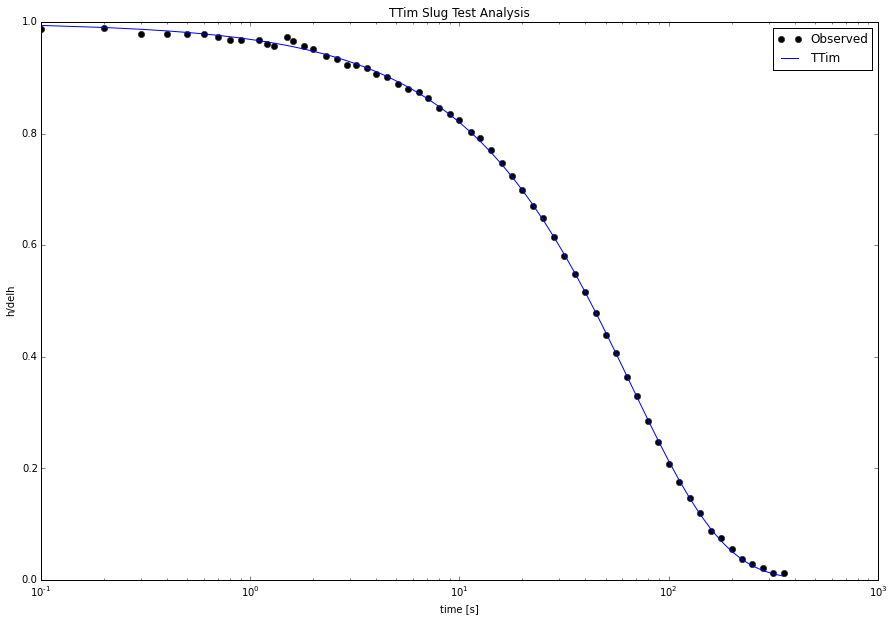

In [6]:
hm = sse(popt, returnheads=True)
plt.figure(figsize=(15,10))
plt.semilogx(time, dd / delh, 'ko', label='Observed')
plt.semilogx(time, hm[0] / delh, 'b', label='TTim')
plt.ylim([0,1])
plt.xlabel('time [s]')
plt.ylabel('h/delh')
plt.legend(loc='best')
plt.title('TTim Slug Test Analysis');

In [7]:
r = pd.DataFrame(columns=['Kr [m/day]','Ss [1/m]'],
                 index=['TTim', 'AQTESOLV'])
r.loc['TTim'] = [popt[0], popt[1]]
r.loc['AQTESOLV'] = [4.034, 0.000384]
r

,Kr [m/day],Ss [1/m]
TTim,6.033339,0.000215509
AQTESOLV,4.034,0.000384
